# SNDAQ Email Alert Plots

Given the SNDAQ alerts scraped from the sn-wg mailing list, plot time series of alert TS $\xi$ and $\xi'$.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime

from astropy.io import ascii

mpl.rc('font', size=14)

## Access Data

Get data from 2017, 2018, and 2019 processed by the web scraper script.

In [3]:
data2017 = ascii.read('sndaq_alerts_2017.txt', names=['sig_cor', 'sig_raw', 'run', 'date', 'time'])
data2018 = ascii.read('sndaq_alerts_2018.txt', names=['sig_cor', 'sig_raw', 'run', 'date', 'time'])
data2019 = ascii.read('sndaq_alerts_2019.txt', names=['sig_cor', 'sig_raw', 'run', 'date', 'time'])

In [4]:
def add_datetime(data):
    thedates = []
    for date, time in zip(data['date'], data['time']):
        thedate = datetime.strptime(' '.join([date, time]), '%Y-%m-%d %H:%M:%S')
        thedates.append(thedate)

    data['datetime'] = thedates
    return data

In [5]:
data2017 = add_datetime(data2017)
data2018 = add_datetime(data2018)
data2019 = add_datetime(data2019)

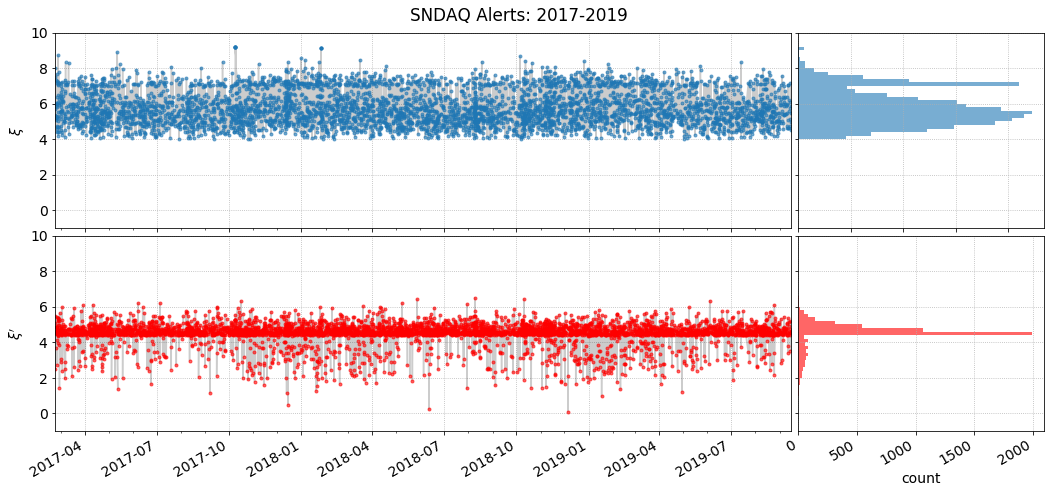

In [11]:
fig, axes = plt.subplots(2,2, figsize=(15,7), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

# dates = data2018['datetime']#, data2019['datetime'])
# sraw = data2018['sig_raw']#, data2019['sig_raw'])
# scor = data2018['sig_cor']#, data2019['sig_cor'])

dates = np.concatenate((data2017['datetime'], data2018['datetime'], data2019['datetime']))#, data2019['datetime'])
sraw = np.concatenate((data2017['sig_raw'], data2018['sig_raw'], data2019['sig_raw']))#, data2019['sig_raw'])
scor = np.concatenate((data2017['sig_cor'], data2018['sig_cor'], data2019['sig_cor']))#, data2019['sig_cor'])

mloc = mpl.dates.MonthLocator(bymonth=(1,4,7,10))

ax = axes[0,0]
ax.plot(dates, sraw, 'k-', alpha=0.2)
ax.plot(dates, sraw, '.', alpha=0.6)
ax.xaxis.set_major_locator(mloc)
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())
ax.set(xlim=[dates[0], dates[-1]],
       ylim=(-1,10),
       ylabel=r'$\xi$')
ax.grid(ls=':')

ax = axes[0,1]
ax.hist(sraw, bins=np.linspace(-1,10,56), orientation='horizontal', alpha=0.6)
ax.grid(ls=':')

ax = axes[1,0]
ax.plot(dates, scor, 'k-', alpha=0.2)
ax.plot(dates, scor, 'r.', alpha=0.6)
ax.xaxis.set_major_locator(mloc)
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())
ax.set(xlim=[dates[0], dates[-1]],
       ylim=(-1,10),
       ylabel=r"$\xi'$")
ax.grid(ls=':')

ax = axes[1,1]
ax.hist(scor, bins=np.linspace(-1,10,56), orientation='horizontal', color='r', alpha=0.6)
ax.set(xlabel='count')
ax.grid(ls=':')

fig.autofmt_xdate()
fig.suptitle('SNDAQ Alerts: 2017-2019')
fig.tight_layout(w_pad=-0.5, h_pad=-0.1, rect=(0,0,1,0.97))

fig.savefig('alert_history_2017_2019.png', dpi=150)

## Stacked Histograms of Alerts

Plot a stacked histogram of the time series of alerts for several "differential" bins in $\xi'$.

### Histogram vs. Time

Use this to get a rough idea of the number of alerts vs. time.

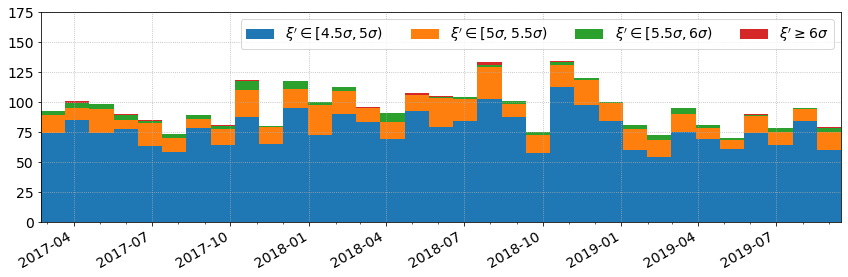

In [7]:
# mbins = np.linspace(datetime(2017,9,1), datetime(2019,9,1), 25)

xi_cut = [4.5, 5., 5.5, 6.]
xi_values = []
xi_labels = []

to_timestamp = np.vectorize(lambda x: int(x.strftime('%s')))

ts = to_timestamp(dates)
tsmin, tsmax = ts[0], ts[-1]
tbins = np.linspace(tsmin, tsmax, 33)

for i in range(len(xi_cut)-1):
    mask = np.logical_and(scor >= xi_cut[i], scor < xi_cut[i+1])
    xi_labels.append(r"$\xi' \in [{:g}\sigma, {:g}\sigma)$".format(xi_cut[i], xi_cut[i+1]))
#     xh = np.histogram(to_timestamp(dates[mask]), bins=tbins)
#     xi_values.append(xh[0])
    xi_values.append(dates[mask])
mask = scor >= xi_cut[-1]
xi_values.append(dates[mask])
xi_labels.append(r"$\xi' \geq {:g}\sigma$".format(xi_cut[-1]))
# xh = np.histogram(to_timestamp(dates[mask]), bins=tbins)
# xi_values.append(xh[0])

fig, ax = plt.subplots(1,1, figsize=(12,4))
# ax.bar(tbins[:-1], xi_values[0])
# ax.bar(tbins, xi_values[0])
ax.hist(xi_values, bins=33, stacked=True, label=xi_labels)
ax.legend(ncol=len(xi_cut))
ax.set(xlim=(dates[0], dates[-1]),
       ylim=(0,175))
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())
ax.grid(ls=':')

fig.autofmt_xdate()
fig.tight_layout();

### Alerts vs. Month: Differential Bins

Instead of the time series, plot the alert frequency as a function of month between 2017 and 2019.

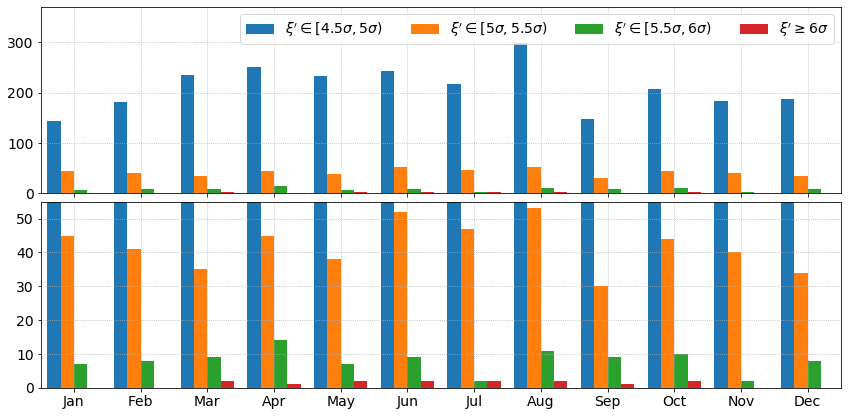

In [8]:
xi_cut = [4.5, 5., 5.5, 6.]
xi_values = []
xi_labels = []

for i in range(len(xi_cut)-1):
    mask = np.logical_and(scor >= xi_cut[i], scor < xi_cut[i+1])
    xi_labels.append(r"$\xi' \in [{:g}\sigma, {:g}\sigma)$".format(xi_cut[i], xi_cut[i+1]))
    xi_values.append([d.month for d in dates[mask]])
mask = scor >= xi_cut[-1]
xi_values.append([d.month for d in dates[mask]])
xi_labels.append(r"$\xi' \geq {:g}\sigma$".format(xi_cut[-1]))

fig, axes = plt.subplots(2,1, figsize=(12,6), sharex=True)
mbins = np.arange(1,14)

ax = axes[0]
ax.hist(xi_values, bins=mbins, align='left', stacked=False, label=xi_labels)
ax.set(xticks=mbins[:-1],
       xlim=(0.5, 12.5),
       xticklabels=[datetime(1900, i, 1).strftime('%b') for i in mbins[:-1]],
       ylim=(0,370))
ax.grid(ls=':')
ax.legend(ncol=len(xi_cut))

ax = axes[1]
ax.hist(xi_values, bins=mbins, align='left', stacked=False, label=xi_labels)
ax.set(xticks=mbins[:-1],
       xlim=(0.5, 12.5),
       xticklabels=[datetime(1900, i, 1).strftime('%b') for i in mbins[:-1]],
       ylim=(0,55))
ax.grid(ls=':')

# fig.autofmt_xdate()
fig.tight_layout(h_pad=0)

### Alerts vs. Month: Integral Bins

Same plot as above, but instead of differential bins in $\xi'$ use integral bins to get a sense of rates for various thresholds on $\xi'$.

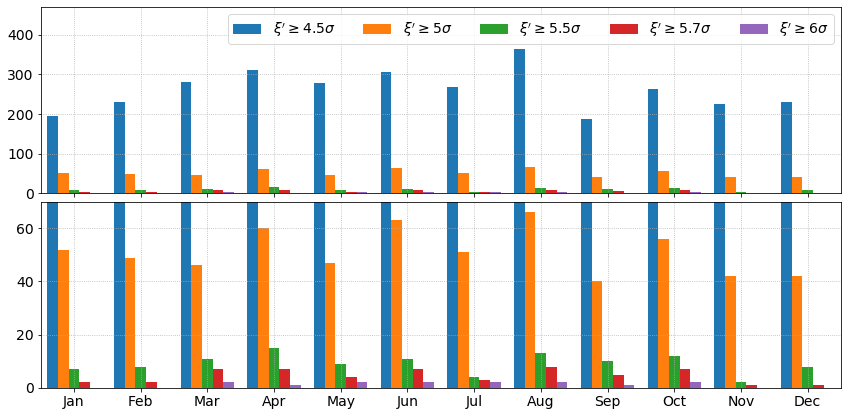

In [9]:
xi_cut = [4.5, 5., 5.5, 5.7, 6.]
xi_values = []
xi_labels = []

for i in range(len(xi_cut)):
    mask = scor >= xi_cut[i]
    xi_labels.append(r"$\xi' \geq {:g}\sigma$".format(xi_cut[i]))
    xi_values.append([d.month for d in dates[mask]])

fig, axes = plt.subplots(2,1, figsize=(12,6), sharex=True)
mbins = np.arange(1,14)

ax = axes[0]
counts, bins, p = ax.hist(xi_values, bins=mbins, align='left', stacked=False, label=xi_labels)
ax.set(xticks=mbins[:-1],
       xlim=(0.5, 12.5),
       xticklabels=[datetime(1900, i, 1).strftime('%b') for i in mbins[:-1]],
       ylim=(0,470))
ax.grid(ls=':')
ax.legend(ncol=len(xi_cut))

ax = axes[1]
ax.hist(xi_values, bins=mbins, align='left', stacked=False, label=xi_labels)
ax.set(xticks=mbins[:-1],
       xlim=(0.5, 12.5),
       xticklabels=[datetime(1900, i, 1).strftime('%b') for i in mbins[:-1]],
       ylim=(0,70))
ax.grid(ls=':')

fig.tight_layout(h_pad=0)

#### Summary Statistics

Using the integral bins, compute the mean number of counts per month and the standard deviation.

In [10]:
for k in range(len(counts)):
    print('xi\' >{:4g} sigma: {:g} {:g}'.format(xi_cut[k], np.average(counts[k]), np.std(counts[k])))

xi' > 4.5 sigma: 261.917 49.0552
xi' >   5 sigma: 51.1667 8.18366
xi' > 5.5 sigma: 9.16667 3.5316
xi' > 5.7 sigma: 4.5 2.53311
xi' >   6 sigma: 1.16667 0.897527
